# uep239 Final project: Where the Book Worms Go
## A Suitability Analysis for where to live for the best reading, public access, and communities for books
### By Kees Schipper

### Suitability for bookworms

What are the conditions needed for an area to be an optimal living space for book worms. A few conditions of importance might be
+ Access to public universities and libraries
+ A population of individuals who are just as enthusiastic about reading as you are
+ closeness to public transportation to get to libraries, if one does not already live near a library
+ Nice outdoor spaces to read, with plenty of shade, parks, and/or grassy areas.

Throughout this analysis, we are going to consider these factors in the form of six variables:
+ population enrolled in a public university -> Used to assess the presence of public universities in a specific area
+ population over 18 years of age -> The older the population, the longer they have had to collect books throughout their lifetime
+ Tree Canopy Cover -> more trees = more shade = more cool park spaces to lie down and get lost in a book.
+ Distance to MBTA bus stops -> Need to get to the Library somehow
+ Distance to MBTA train stops -> see above
+ Distance to Public Library -> for obvious reasons

Below, we'll start by importing all of the libraries that we are going to use for this analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

import rasterio
from rasterio.plot import show
from rasterio import features

# import richdem as rd
from scipy import ndimage
# from shapely.geometry import box
from rasterstats import zonal_stats
import os

# finally, check working directory to see where we are in our file structure
os.getcwd()

'C:\\Users\\keess\\OneDrive\\Documents\\Tufts Friedman School\\Semester 4\\Geospatial Programming with Python\\uep239FinalProj\\notebooks'

### Change current working directory to the data folder for easier reading of files

In [2]:
os.chdir("../Data")

## Part 1: Reading in our data

### 1a: Tabular Data

In [3]:
# reading in ACS tables for Age, sex, and education
AgeSex = pd.read_csv("AgeACS.csv", header = 0, skiprows=[1])
Edu = pd.read_csv("EduAttainmentACS.csv", header = 0, skiprows = [1])

# select only columns that have data of interest to you, plus columns containing primary keys
AgeSex_cols = AgeSex[['GEO_ID', 'NAME', 'S0101_C01_022E', 'S0101_C01_026E', 'S0101_C02_026E']].copy()
Edu_cols = Edu[['GEO_ID', 'NAME', 'S1401_C03_010E', 'S1401_C04_010E']].copy()

# rename columns to be more intuitive
AgeSex_cols = AgeSex_cols.rename(columns = {"S0101_C01_022E":"popUnder18", "S0101_C01_026E":"popOver18", "S0101_C02_026E":"pctOver18"})
Edu_cols = Edu_cols.rename(columns = {"S1401_C03_010E":"popInCollege", "S1401_C04_010E":"pctInCollege"})

print(AgeSex_cols.columns)
print(Edu_cols.columns)

Index(['GEO_ID', 'NAME', 'popUnder18', 'popOver18', 'pctOver18'], dtype='object')
Index(['GEO_ID', 'NAME', 'popInCollege', 'pctInCollege'], dtype='object')


#### Let's also look at some basic descriptions of our data to see what we're dealing with

In [4]:
AgeSex_cols.describe()

,popUnder18,popOver18
count,537.000000,537.000000
mean,2553.556797,10203.417132
std,2702.400435,10291.627226
min,0.000000,0.000000
25%,404.000000,2141.000000
50%,1656.000000,6988.000000
75%,3771.000000,14533.000000
max,16734.000000,51217.000000


In [5]:
# needed to check if there were any outlying/unrealistic values for any of my variables
AgeSex_cols.pctOver18.unique()

# remove the non-numeric entries in the column ('-')
AgeSex_cols.pctOver18 = AgeSex_cols.pctOver18.str.replace(pat = '-', repl = '0.0', regex = False)
# convert cleaned series into a float series
AgeSex_cols.pctOver18 = AgeSex_cols.pctOver18.astype("float")

# check that everything works as it should.
AgeSex_cols.describe()

,popUnder18,popOver18,pctOver18
count,537.000000,537.000000,537.000000
mean,2553.556797,10203.417132,81.016201
std,2702.400435,10291.627226,9.185791
min,0.000000,0.000000,0.000000
25%,404.000000,2141.000000,77.300000
50%,1656.000000,6988.000000,80.300000
75%,3771.000000,14533.000000,84.700000
max,16734.000000,51217.000000,100.000000


In [6]:
Edu_cols.describe()

,popInCollege
count,537.000000
mean,519.957169
std,859.161892
min,0.000000
25%,74.000000
50%,282.000000
75%,600.000000
max,10248.000000


Interesting...it seems like pctInCollege is not a numeric object. Let's explore why that is

In [32]:
print(Edu_cols.dtypes) # pctInCollege is an object, likely meaning there is some type of character string preventing it from being numeric
print(Edu_cols.pctInCollege.unique())

GEO_ID           object
NAME             object
popInCollege      int64
pctInCollege    float64
dtype: object
[ 48.8  75.7  90.7  72.1  62.8  37.8   0.   40.3  75.3 100.   60.4  72.3
  72.4  65.5  70.5  66.1  56.1  30.6  60.   64.9  74.7  77.2  61.3  78.3
  77.   81.1  87.8  62.3  66.5  41.4  35.4  56.   64.3  48.5  82.4  64.4
  36.8  73.4  87.3  90.1  78.1  75.5  81.3  90.4  61.5  72.8  40.   61.1
  57.6  50.   81.6  85.7  24.6  71.9  79.8  63.9  44.4  91.   63.8  83.6
  63.3  62.7  93.4  63.7  21.5  77.1  58.8  35.8  72.2  27.8  76.2  56.3
  65.4  37.   57.1  19.6  55.6  24.2  82.8  68.8  86.7  91.1  46.9  66.7
  47.2  84.2  87.1  47.7  85.   85.2  63.2  46.   72.7  68.4  76.6  97.7
  50.8  71.8  57.9  47.9  43.5  84.5  58.6  70.7  67.3  71.   78.7  67.4
  47.3  84.3  81.   91.8  90.2  67.2  65.1  34.9  78.5  61.6  69.4  83.5
  47.6  54.6  88.4  54.9  49.9  71.2  64.5  61.2  42.6  39.7  62.5  39.2
  51.5  79.6  71.4  51.2  59.3  53.7  42.5  78.8  52.   75.4  36.9  59.1
  62.4  65.   

In the unique values, we see that there is one entry that is a `'-'` instead of a number, which is preventing python from interpreting this series as a float. Let's remove that string value and change it to 0.0, then we can convert the series to a float.

In [33]:
# replace the problematic string
Edu_cols.pctInCollege = Edu_cols.pctInCollege.str.replace(pat = '-', repl = '0.0', regex = False)

# change the series into a float data type
Edu_cols.pctInCollege = Edu_cols.pctInCollege.astype("float")


AttributeError: Can only use .str accessor with string values!

In [34]:
# check the dtype and summary of the dataset
print(Edu_cols.pctInCollege.dtype)
Edu_cols.describe()
# we now have a dataset that we can work with!!

float64


,popInCollege,pctInCollege
count,537.000000,537.000000
mean,519.957169,55.576536
std,859.161892,25.895560
min,0.000000,0.000000
25%,74.000000,40.700000
50%,282.000000,60.300000
75%,600.000000,74.400000
max,10248.000000,100.000000


### Part 1b: Reading in Shapefiles

In [35]:
# read in files with intuitive names
Libs = gpd.read_file("LIBRARIES_PT.shp")
mbta_node = gpd.read_file("MBTA_NODE.shp")
MPO_Bounds = gpd.read_file("MPO_Boundaries.shp")
ZCTA = gpd.read_file("tl_2010_25_zcta510.shp")
mbta_bus = gpd.read_file("MBTA_Bus_Stops.shp")

See what the CRS values are for each of our shapefiles

In [36]:
print(Libs.crs)
print(mbta_node.crs)
print(MPO_Bounds.crs)
print(ZCTA.crs)
print(mbta_bus.crs)
# looks like we have 3 different CRS values for our shapefiles, which is an easy thing to fix.

epsg:26986
epsg:26986
epsg:3857
epsg:4269
epsg:26986


We need to change the epsg for MPO_Bounds and ZCTA to match the other shapefile's CRS (EPSG:26986)

In [12]:
MPO_Bounds.to_crs(epsg = "26986", inplace=True)
ZCTA.to_crs(epsg = "26986", inplace = True)
print(MPO_Bounds.crs)
print(ZCTA.crs)

epsg:26986
epsg:26986


### Let's try overlaying the maps to see that they all line up

<AxesSubplot:>

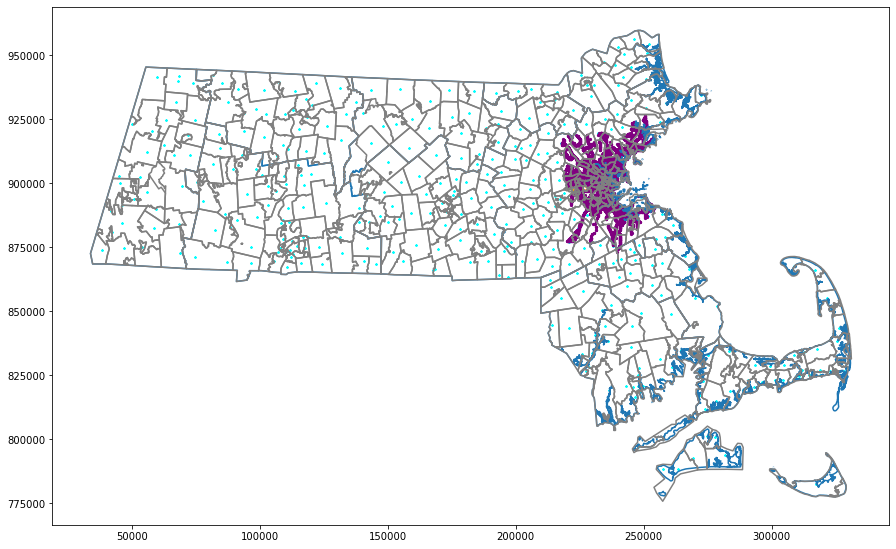

In [13]:
fig, ax = plt.subplots(1, 1, figsize = (15, 15))
MPO_Bounds.boundary.plot(ax = ax)
ZCTA.boundary.plot(ax = ax, color = "grey")
Libs.plot(ax = ax, color = "cyan", marker = "*", markersize = 4)
mbta_node.plot(ax = ax, color = "orange", markersize = 5)
mbta_bus.plot(ax = ax, color = "purple", markersize = 5)

All Checks out

In [14]:
# Check the unit of measure for our crs files.
ZCTA.crs

<Projected CRS: EPSG:26986>
Name: NAD83 / Massachusetts Mainland
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Massachusetts onshore - counties of Barnstable; Berkshire; Bristol; Essex; Franklin; Hampden; Hampshire; Middlesex; Norfolk; Plymouth; Suffolk; Worcester.
- bounds: (-73.5, 41.46, -69.86, 42.89)
Coordinate Operation:
- name: SPCS83 Massachusetts Mainland zone (meters)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

It appears that our unit of measurement for EPSG:26986 is in meters. This will come in handy later when we reclassify our datasets

So far, it looks like everything lines up pretty nicely, but we should limit our study area to just the boston metropolitan area...We need to find which region in MPO_Bounds corresponds to Boston, and then clip all of our shapefiles to that region.

['Berkshire' 'Cape Cod' 'Central Massachusetts' 'Franklin' 'Montachusett'
 "Martha's Vineyard" 'Merrimack Valley' 'Northern Middlesex' 'Nantucket'
 'Pioneer Valley' 'Boston Region' 'Old Colony'
 'Southeastern Massachusetts']


,OBJECTID,MPO,created_us,created_da,last_edite,last_edi_1,GlobalID,ShapeSTAre,ShapeSTLen,geometry
10,12,Boston Region,None,1970-01-01,DINOCCOD,2018-04-18,{3801574E-3CF1-4344-BE7C-8B2FBA431DD8},3.524379e+09,1.665026e+06,"MULTIPOLYGON (((261954.246 925125.468, 261961...."


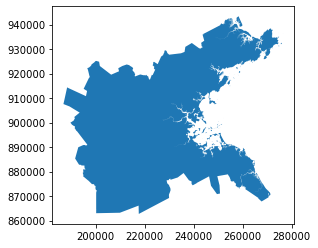

In [15]:
print(MPO_Bounds.MPO.unique())
Bos_Bounds = MPO_Bounds[MPO_Bounds.MPO == 'Boston Region'].copy()
Bos_Bounds.plot()
Bos_Bounds

Now we need to clip all of our other data (`ZCTA`, `Libs`, `mbta_node`) to the extent of Bos_Bounds. We can do this using the `gpd.clip()` function

<AxesSubplot:>

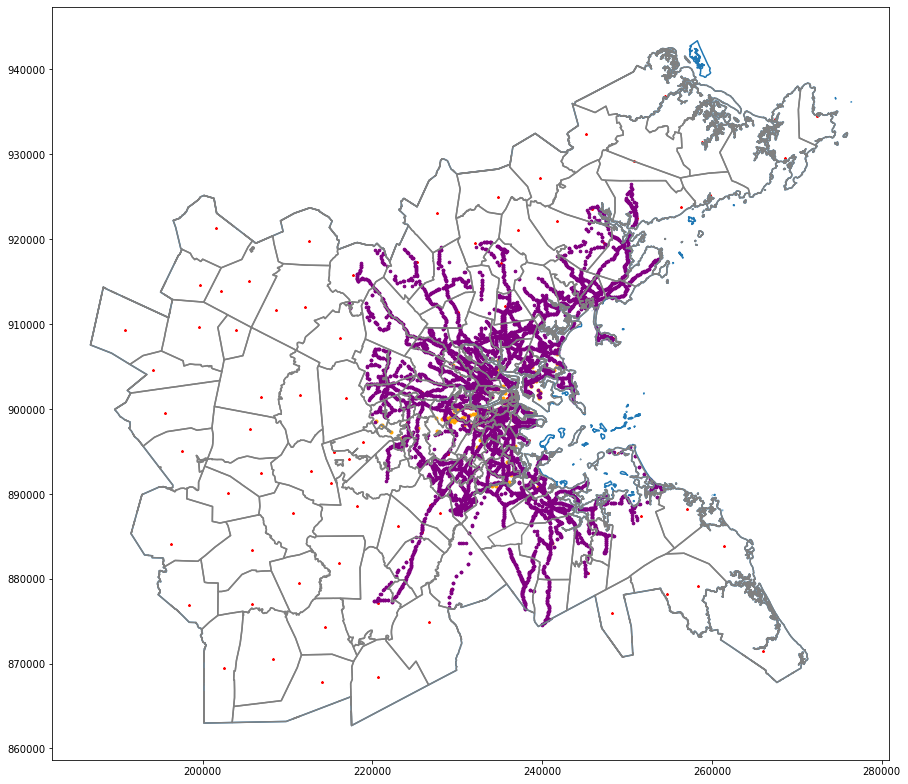

In [16]:
ZCTA_clip = gpd.clip(ZCTA, Bos_Bounds)
Libs_clip = gpd.clip(Libs, Bos_Bounds)
mbta_clip = gpd.clip(mbta_node, Bos_Bounds)
bus_clip = gpd.clip(mbta_bus, Bos_Bounds)

# check that the clip was effective
fig, ax = plt.subplots(1, 1, figsize = (15, 15))
Bos_Bounds.boundary.plot(ax = ax)
ZCTA_clip.boundary.plot(ax = ax, color = "grey")
Libs_clip.plot(ax = ax, color = "red", markersize = 5, marker = "*")
mbta_clip.plot(ax = ax, color = "orange", markersize = 9)
bus_clip.plot(ax = ax, color = "purple", markersize = 7)

At this point in our analysis, we only really need the Bos_bounds vector data to clip other rasters. All the data for our vulnerability analyses are in our other data sets

### 1c: Read in Raster data

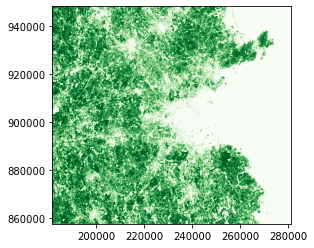

(30.0, 30.0) 
 EPSG:6491 
 None 
 BoundingBox(left=181770.0, bottom=857670.0, right=281430.0, top=948390.0) 
 (3024, 3322)


In [17]:
with rasterio.open("NLCD_2016_Tree_Canopy_Boston.tif") as treecover:
    trees = treecover.read(1)
    transform = treecover.transform # save a transform so that we can be consistent for all of our data
    res = treecover.res
    crs = treecover.crs
    nodata = treecover.nodata
    bounds = treecover.bounds
    shape = treecover.shape

# get rid of no data values (255 doesn't represent any data, and gets in the way of tree canopy calculations)
trees[trees == 255] = 0    

show(trees, transform = transform, cmap = "Greens")
print(res, "\n", crs, "\n", nodata, "\n", bounds, "\n", shape)

## Part 2: Rasterizing Point Data

We can use the `features.rasterize` function to turn our MBTA train, bus, and library points into rasters. We can then calculate the distance from any point in our newly made rasters to our landmark of interest. This can then be used for scoring our data, where any point beyond a certain distance gets a specific score from 1-5.

In [18]:
# First, we need to turn our point features into raster features
mbta_ras = features.rasterize(mbta_clip['geometry'], out_shape = shape, fill = 1, transform = transform, default_value = 0)
Libs_ras = features.rasterize(Libs_clip['geometry'], out_shape = shape, fill = 1, transform = transform, default_value = 0)
bus_ras = features.rasterize(mbta_bus['geometry'], out_shape = shape, fill = 1, transform = transform, default_value = 0)

26208.493927191903
7954.845845902801
15968.738521634914


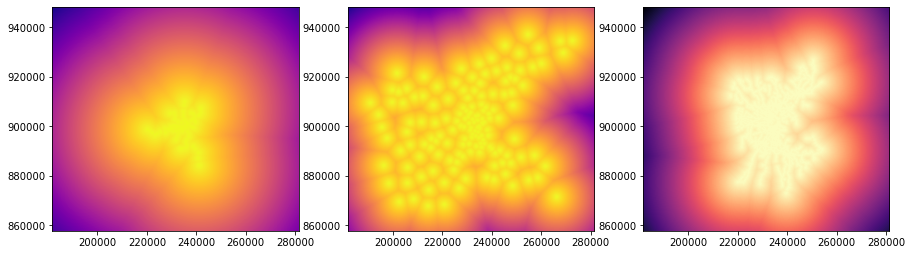

In [19]:
# now we can make a distance matrix, and set the resolution to be equivalent to that of the tree cover matrix
mbta_dist = ndimage.distance_transform_edt(mbta_ras) * res[0]
Lib_dist = ndimage.distance_transform_edt(Libs_ras) * res[0]
bus_dist = ndimage.distance_transform_edt(bus_ras) * res[0]

# let's see how our distance rasters look with some pretty colors
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 20))

show(mbta_dist, transform = transform, ax = ax1, cmap = 'plasma_r')
show(Lib_dist, transform = transform, ax = ax2, cmap = 'plasma_r')
show(bus_dist, transform = transform, ax = ax3, cmap = 'magma_r')
print(mbta_dist.mean())
print(Lib_dist.mean())
print(bus_dist.mean())

Above is an example of how the distances look from our values of interest. Libraries look a lot more spread out than train stops, though bus stops look like the most densely clustered point data.

Let's create a 5-level reclassification structure for both MBTA distance and Library distances

<AxesSubplot:>

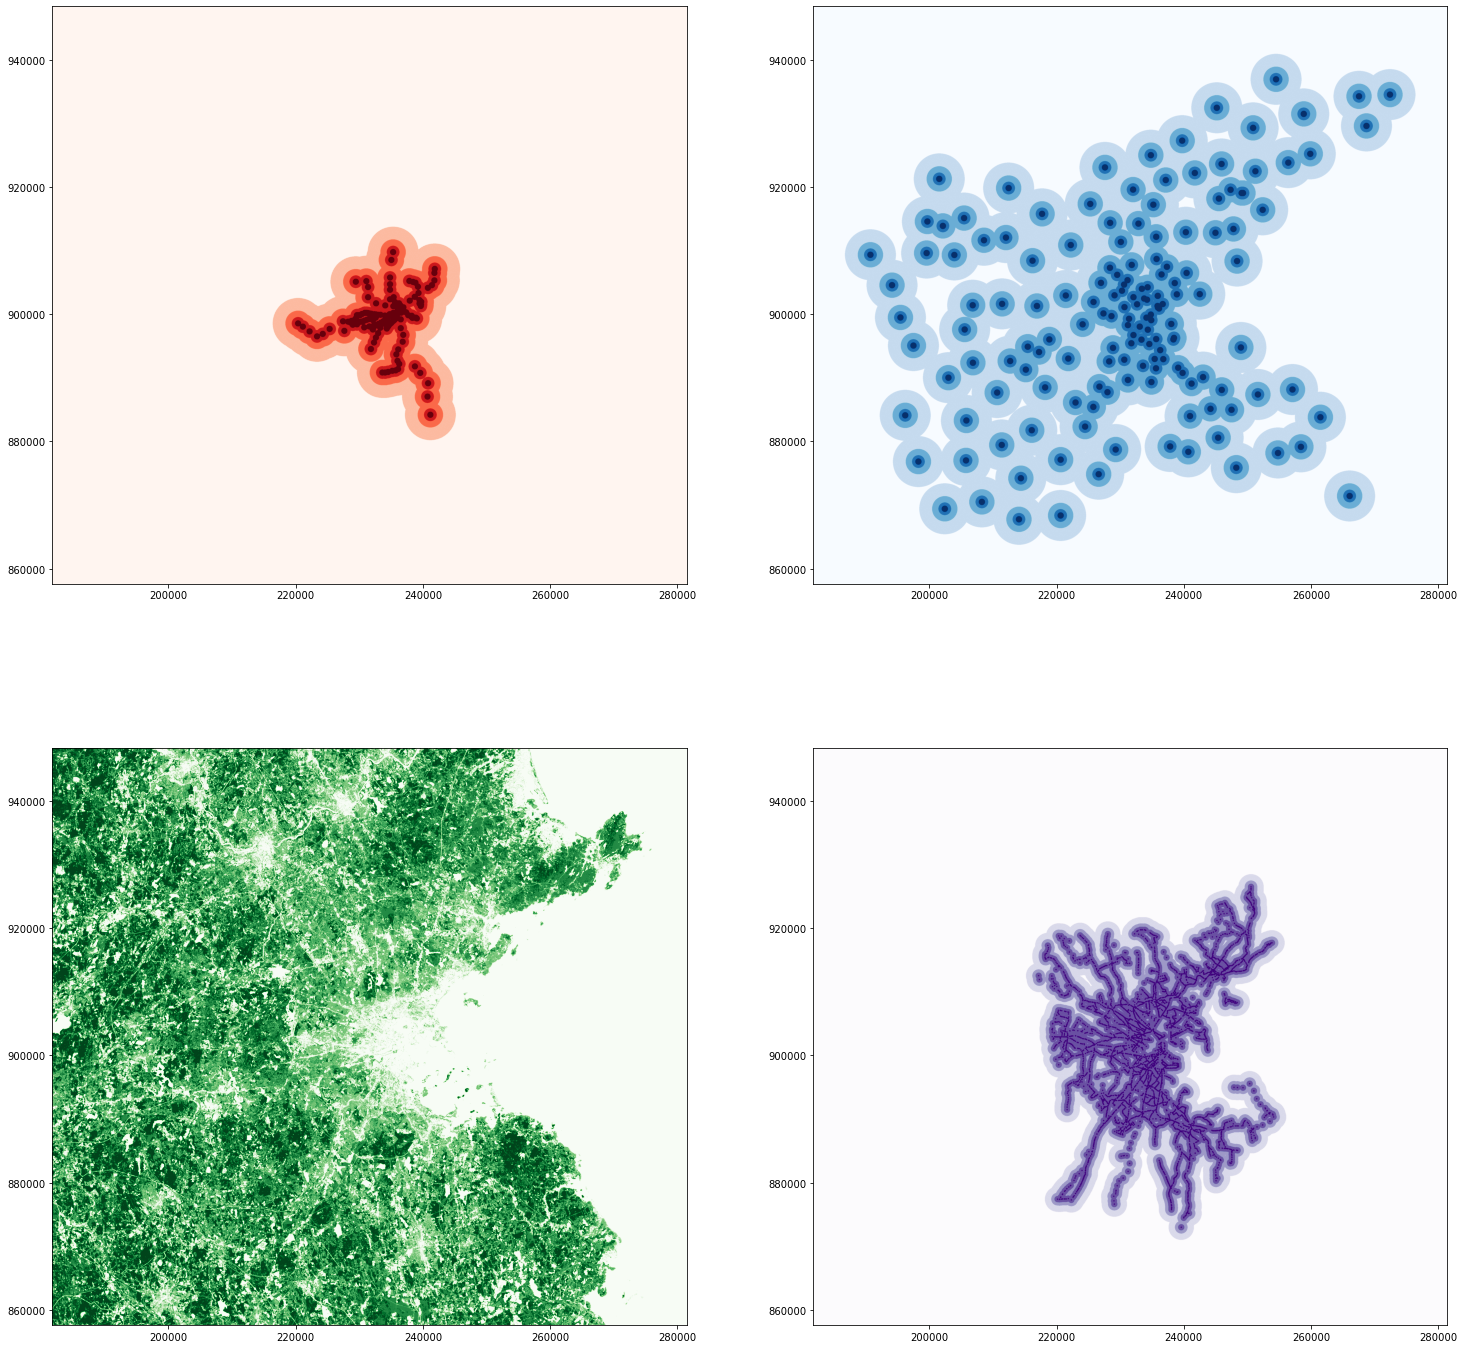

In [20]:
def classify5Quants(raster, lowdist = "good", q = None, cuts = None):
    
    """Reclassify a raster into 5 categories. User either provides 4 quantile values with the q parameter in the form of a list (e.g. q = [0.2, 0.4, 0.6, 0.8]),
    or provides 4 cuts via the cuts parameter, where the cuts correspond to potential data values in a raster. Quantiles break by
    percentages in the raster, while cuts breaks the raster by specified values (e.g. distance from a point of interest in the raster).
    If a distance raster is inputted, cuts specify distance to an object that you are breaking
    your categorizations by. lowdist is what determines how the scoring is handled, and can take the values of 'good' or 'bad'. if lowdist == 'good', then the lowest
    distances are given a value of 5, with higher distances going to values of 4, 3, 2, etc... If lowdist == 'bad', then the reverse is true, and lowest distances will get
    values of 1. The user can only provide quantiles via q, or cuts. If q and cuts are provided, only breaks from q are returned to the user. The output of this function
    is a raster of the same size as the input, but with only values 1-5 based on the scoring criteria."""
    
    output = np.full(shape = raster.shape, fill_value = np.NaN)
    
    if q:
        quants = np.quantile(raster, q)
        if lowdist == "bad":
            output[raster <= quants[0]] = 1
            output[(raster > quants[0]) & (raster <= quants[1])] = 2
            output[(raster > quants[1]) & (raster <= quants[2])] = 3
            output[(raster > quants[2]) & (raster <= quants[3])] = 4
            output[raster > quants[3]] = 5

            return output

        elif lowdist == "good":
            output[raster <= quants[0]] = 5
            output[(raster > quants[0]) & (raster <= quants[1])] = 4
            output[(raster > quants[1]) & (raster <= quants[2])] = 3
            output[(raster > quants[2]) & (raster <= quants[3])] = 2
            output[raster > quants[3]] = 1

            return output

        else:
            raise Exception("lowdist must either be 'good' or 'bad', meaning that in your scoring algorithms, low distances are either 'good' or 'bad' for your scoring")
    
    elif cuts:
        if lowdist == "bad":
            output[raster <= cuts[0]] = 1
            output[(raster > cuts[0]) & (raster <= cuts[1])] = 2
            output[(raster > cuts[1]) & (raster <= cuts[2])] = 3
            output[(raster > cuts[2]) & (raster <= cuts[3])] = 4
            output[raster > cuts[3]] = 5

            return output

        elif lowdist == "good":
            output[raster <= cuts[0]] = 5
            output[(raster > cuts[0]) & (raster <= cuts[1])] = 4
            output[(raster > cuts[1]) & (raster <= cuts[2])] = 3
            output[(raster > cuts[2]) & (raster <= cuts[3])] = 2
            output[raster > cuts[3]] = 1

            return output

        else:
            raise Exception("lowdist must either be 'good' or 'bad', meaning that in your scoring algorithms, low distances are either 'good' or 'bad' for your scoring")
            

mbta_reclass = classify5Quants(raster = mbta_dist, cuts = [500, 1000, 2000, 4000], lowdist = "good")
Lib_reclass = classify5Quants(raster = Lib_dist, cuts = [500, 1000, 2000, 4000], lowdist = "good")
trees_reclass = classify5Quants(raster = trees, q = [.20, .40, .60, .80], lowdist = "bad")
bus_reclass = classify5Quants(raster = bus_dist, cuts = [100, 500, 1000, 2000], lowdist = "good")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (25, 25))

show(mbta_reclass, transform = transform, cmap = 'Reds', ax = ax1)
show(Lib_reclass, transform = transform, cmap = 'Blues', ax = ax2)
show(trees_reclass, transform = transform, cmap = 'Greens', ax = ax3)
show(bus_reclass, transform = transform, cmap = "Purples", ax = ax4)

As you can see by the figure above, all of our data are on the same scale, and could be added together to form a weight raster. However, I still want to look at a couple variables, such as the population of zipcode areas over 18 years and the population of individuals enrolled in college/graduate school in a public university.

Currently, we have complete rasters on four of our 6 desired factors
1. Proximity to public Libraries
2. Proximity to MBTA nodes
3. Proximity to MBTA bus stops
4. Different levels of tree canopy 

Now, we need to combine tabular data from our read-in csv files, and join them to a GeoDataFrame

## Part 3: Incorporating tabular data

Now we need to join our tabular data by attribute to a reference shapefile. To do this, we can first combine the age, sex, and education data into one tabular data frame, and then combine that data frame to our clipped ZCTA data via the `ZCTA5CE10` variable, keeping only rows where the key is already in the ZCTA_clip data frame. That way we will only get data in the Boston study area.

In [21]:
print(Edu_cols.columns)
print(AgeSex_cols.columns)
AgeEdu = Edu_cols.merge(AgeSex_cols, how = "outer", on = ['GEO_ID', 'NAME'])
AgeEdu[['GEO_ID1', 'ZCTA5CE10']] = AgeEdu.GEO_ID.str.split(pat = "US", n = 1, expand = True)

Index(['GEO_ID', 'NAME', 'popInCollege', 'pctInCollege'], dtype='object')
Index(['GEO_ID', 'NAME', 'popUnder18', 'popOver18', 'pctOver18'], dtype='object')


In [22]:
ZCTA_clip.head()

,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry
17,25,01905,2501905,B5,G6350,S,9219345,1195154,+42.4659985,-070.9757922,N,"MULTIPOLYGON (((243877.753 913824.638, 243872...."
18,25,01904,2501904,B5,G6350,S,11708211,1303900,+42.4924563,-070.9739297,N,"POLYGON ((245700.484 914778.700, 245667.412 91..."
20,25,01930,2501930,B5,G6350,S,67847425,13972397,+42.6199100,-070.6818235,N,"MULTIPOLYGON (((261745.067 931625.267, 261822...."
21,25,01915,2501915,B5,G6350,S,39091336,3958118,+42.5702688,-070.8669962,N,"MULTIPOLYGON (((250787.714 926889.372, 251155...."
22,25,01921,2501921,B5,G6350,S,61010486,2188501,+42.6831083,-071.0183302,N,"MULTIPOLYGON (((245193.985 936821.773, 244097...."


In [23]:
AgeEdu.head()

,GEO_ID,NAME,popInCollege,pctInCollege,popUnder18,popOver18,pctOver18,GEO_ID1,ZCTA5CE10
0,8600000US01001,ZCTA5 01001,520,48.8,3167,14145,81.7,8600000,01001
1,8600000US01002,ZCTA5 01002,9305,75.7,3768,26246,87.4,8600000,01002
2,8600000US01003,ZCTA5 01003,10248,90.7,139,11218,98.8,8600000,01003
3,8600000US01005,ZCTA5 01005,245,72.1,1005,4123,80.4,8600000,01005
4,8600000US01007,ZCTA5 01007,677,62.8,3399,11606,77.3,8600000,01007


After the merge, we should look to visualize our data to see the spatial distribution of our ACS demographic variables

<AxesSubplot:title={'center':'Population over 18'}>

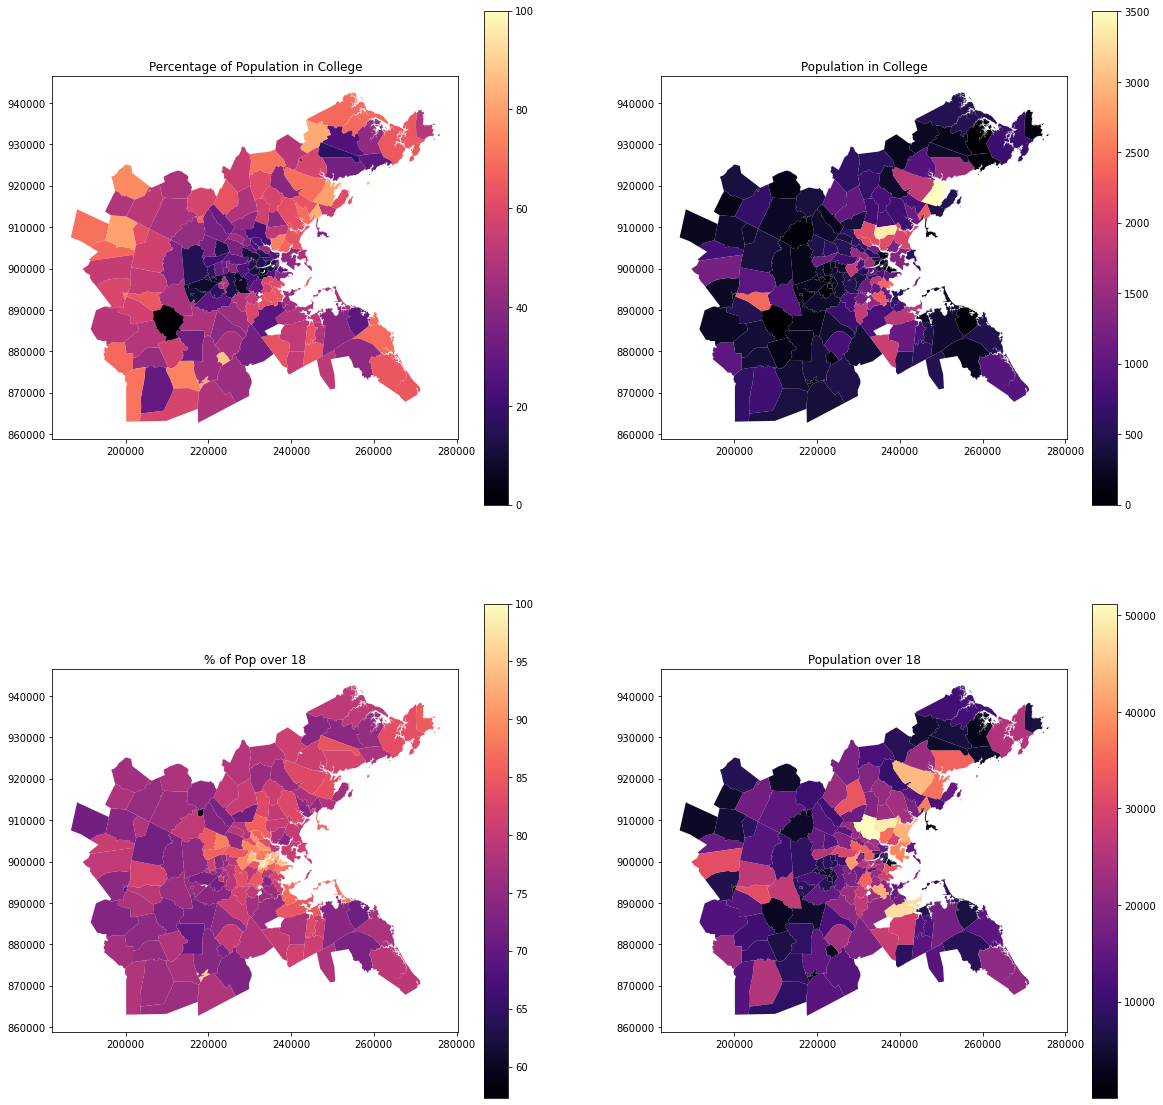

In [39]:
ZCTA_AgeEdu = ZCTA_clip.merge(AgeEdu, on = 'ZCTA5CE10', how = 'left')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 20))
ax1.set_title("Percentage of Population in College")
ZCTA_AgeEdu.plot(column = 'pctInCollege', cmap = 'magma', legend = True, ax = ax1)
ax2.set_title("Population in College")
ZCTA_AgeEdu.plot(column = 'popInCollege', cmap = 'magma', legend = True, ax = ax2)
ax3.set_title("% of Pop over 18")
ZCTA_AgeEdu.plot(column = 'pctOver18', cmap = 'magma', legend = True, ax = ax3)
ax4.set_title("Population over 18")
ZCTA_AgeEdu.plot(column = 'popOver18', cmap = 'magma', legend = True, ax = ax4)

### Part 3b: create a function that takes vector data, and reclassifies a column into 5 quantiles.

<AxesSubplot:title={'center':'percent over 18, reclassified'}>

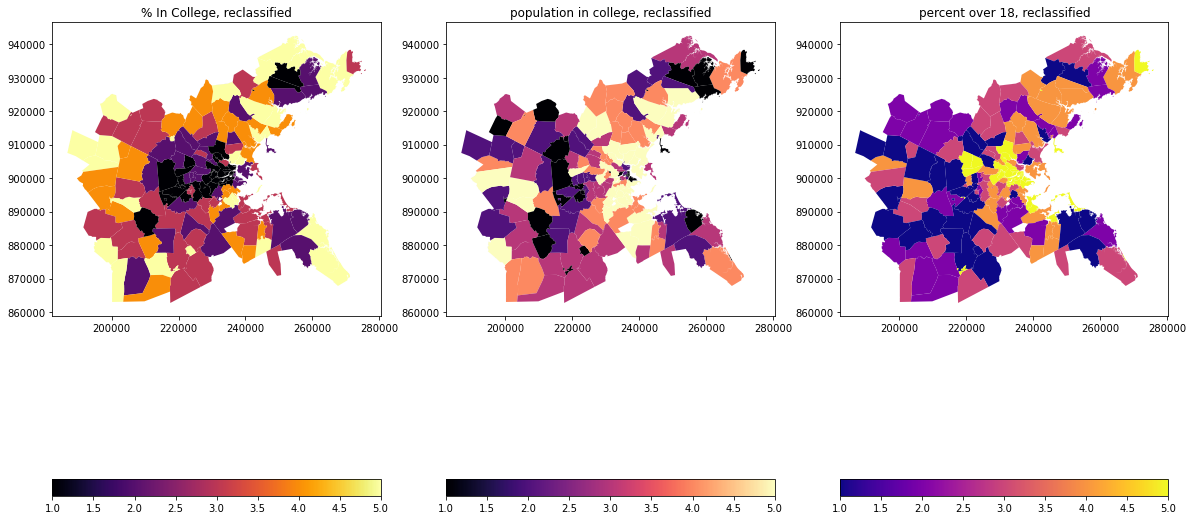

In [46]:
def reclassVec5(series, high = "good"):
    
    """This function is similar to the previous function in this script, called classify5Quants. However, this function operates on vector data rather than raster data. 
    This function reclassifies the values of a series based on 20%, 40%, 60%, and 80% quantiles, creating 5 groups. In addition, the argument 'high' lets the user specify
    the direction of the scoring. If high == 'good', then high values of a series are rescored as a 5, and low values as a 1. if high == 'bad', the behavior is reversed.
    The user can only specify a series and whether high values in that series are 'good' or 'bad'. 'good' and 'bad' are the only two options for the high argument, and all others
    will throw an error."""
    
    quant = series.quantile(q = [0.2, 0.4, 0.6, 0.8])
    newcol = series.copy()
    i = 0
    
    for item in series:
        if high == "bad":
            if item <= quant.iloc[0]:
                newcol.iloc[i] = 5
            elif item > quant.iloc[0] and item <= quant.iloc[1]:
                newcol.iloc[i] = 4
            elif item > quant.iloc[1] and item <= quant.iloc[2]:
                newcol.iloc[i] = 3
            elif item > quant.iloc[2] and item <= quant.iloc[3]:
                newcol.iloc[i] = 2
            else:
                newcol.iloc[i] = 1
                
        elif high == "good":
            if item <= quant.iloc[0]:
                newcol.iloc[i] = 1
            elif item > quant.iloc[0] and item <= quant.iloc[1]:
                newcol.iloc[i] = 2
            elif item > quant.iloc[1] and item <= quant.iloc[2]:
                newcol.iloc[i] = 3
            elif item > quant.iloc[2] and item <= quant.iloc[3]:
                newcol.iloc[i] = 4
            else:
                newcol.iloc[i] = 5

        else:
            raise Exception("high must be either 'good' or 'bad'. If high is 'good', high quantiles will have high scores")
        
        i += 1
        
    return newcol
        
        
ZCTA_AgeEdu['pctInCol_Reclass'] = reclassVec5(series = ZCTA_AgeEdu['pctInCollege'], high = "good")
ZCTA_AgeEdu['popInCol_Reclass'] = reclassVec5(series = ZCTA_AgeEdu['popInCollege'], high = "good")
ZCTA_AgeEdu['pctOv18_Reclass'] = reclassVec5(series = ZCTA_AgeEdu['pctOver18'], high = "good")

fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 20))

ax1.set_title(label = '% In College, reclassified')
ZCTA_AgeEdu.plot(column = 'pctInCol_Reclass', ax = ax1, cmap = 'inferno', legend = True, legend_kwds = {'orientation': "horizontal"})
ax2.set_title(label = "population in college, reclassified")
ZCTA_AgeEdu.plot(column = 'popInCol_Reclass', ax = ax2, cmap = "magma", legend = True, legend_kwds = {'orientation': "horizontal"})
ax3.set_title(label = "percent over 18, reclassified")
ZCTA_AgeEdu.plot(column = 'pctOv18_Reclass', ax = ax3, cmap = "plasma", legend = True, legend_kwds = {'orientation': "horizontal"})

Above, we can see our 5-level reclassification of ZCTAs, where 5 represents a "good" score for bookworms, whereas 1 represents a "bad" score for bookworms. Areas where a high percentage of individuals are enrolled in college may have a large number of people from whom one could borrow books from. On the other hand, sparsely populated areas might have high percentages of college enrolled students, but that may not add up to a really large number of students who you could borrow books from. In fact, it looks like low percentages of individuals enrolled in colleges is more predictive of total population size rather than number of students in college, even though there is likely a higher density of colleges within cities. On the other hand, the second graph shows areas with the highest absolute concentration of college-enrolled population, which is closer to downtown Boston, Newton, Brookline, and northern suburbs like Malden and Sommerville. These areas likely have a large number of students from whom one could borrow books (if you make the right connections). The last map, percent over 18, shows areas where again, readers could go to make connections to borrow books. The older someone is, the more time that they may have had to accumulate books in their life. Therefore, high percentages of population over 18 shows the viable percentage of population who you could borrow books from.

## Part 4: zonal statistics and converting rasters to polygons

Let's start by making a function so that we can first see our raster with a boundary overlay, calculate zonal statistics, display the zonal statistics, and return a polygon layer

The four raster layers we have are named the following:
+ mbta_reclass
+ Lib_reclass
+ trees_reclass
+ bus_reclass

And our boundary layer is named `ZCTA_AgeEdu`

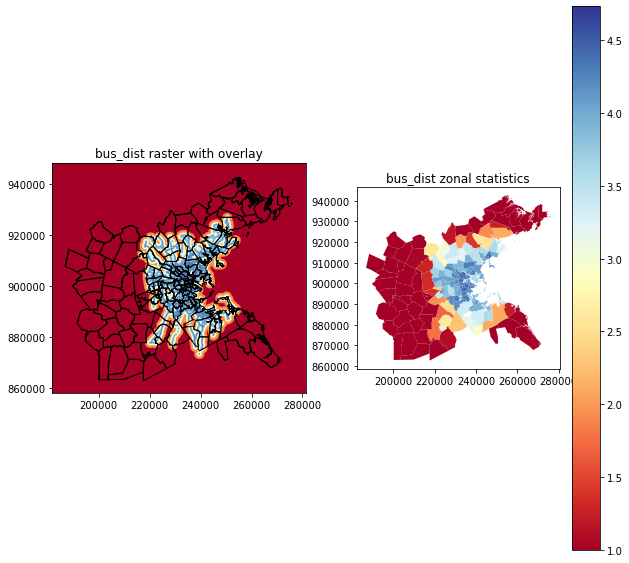

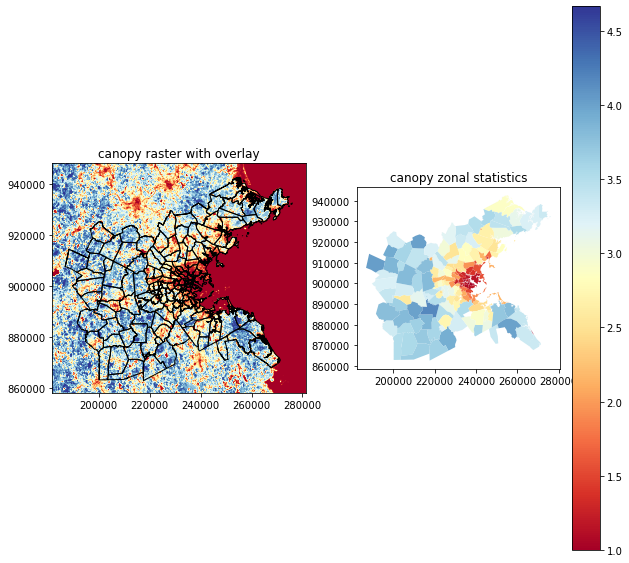

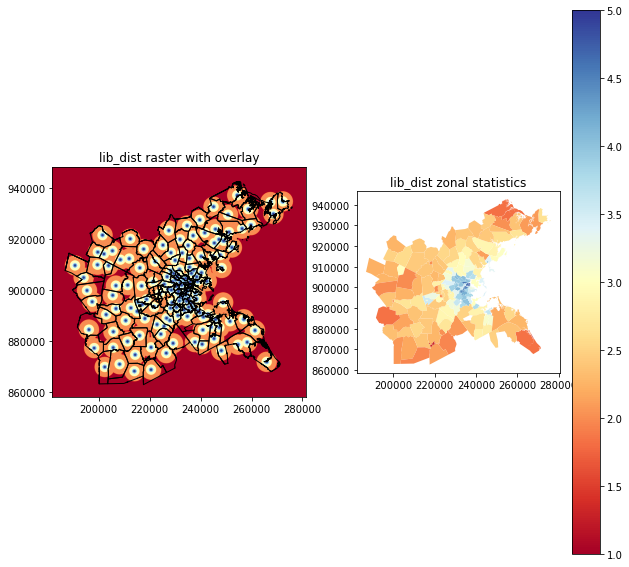

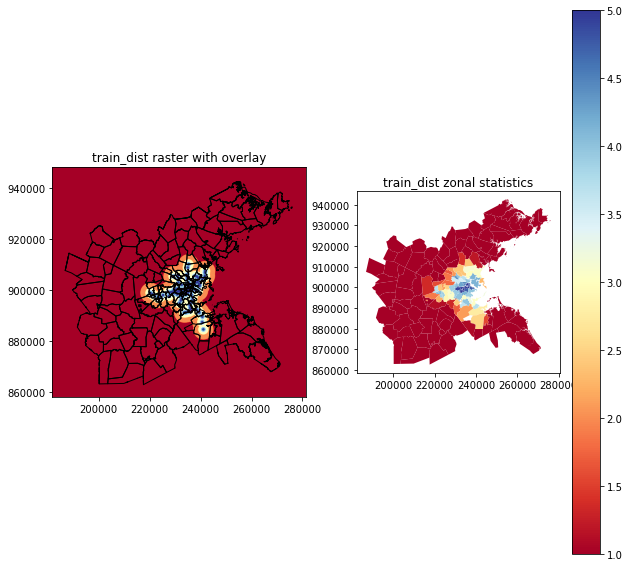

In [26]:
def rasterToPolygon(raster, zones, stats = ['mean'], colors = "Purples", plotcol = 'mean', nodata = np.NaN, label = ''):
    """This function takes a raster and a shapefile, calculates zonal statistics for that raster within each zone provided, and allows the user to customize
    the color of an outputted choropleth, the column that is plotted in the choropleth (must be a value present in the stats argument), and allows the user to label their
    plots. The argument 'raster' is a raster input. 'zones' is the shapefile in which you want zonal statistics to be calculated. 'stats' can be inputted as a single value,
    or a list of summary statistics calculable by the function 'zonal_stats' from the package 'rasterstats' (mean, median, min, max, etc...). 'colors' can be any palette in the
    matplotlib palette library. 'label' will be the the prefix to whatever outcome variables come from this function (for example, if you put label = 'bus_distance', the function
    will give you a series with the column bus_distance_mean if you calculate a mean value). This function returns a pandas DataFrame with indices corresponding to your input
    vector data, with a column for each summary statistic that was calculated. NOTE: currently, the function only works for a single summary statistic, as this was all I needed
    to complete the project. Therefore, the function is programmed assuming only one summary statistic input."""
    
    
    # step 1: display raster with boundary overlay
    fig, (axr, axp) = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 10))
    zones.plot(facecolor = "None", edgecolor = 'black', ax = axr)
    axr.set_title(label = "%s raster with overlay" %label)
    
    show(raster, transform = transform, cmap = colors, ax = axr)
    
    # step 2: calculate zonal statistics
    calcstats = pd.DataFrame(zonal_stats(zones, raster, affine=transform, stats = stats, nodata = nodata))
    
    newlab = "%s_%s" %(label, stats[0])
    calcstats.rename(columns = {stats[0]:"%s_%s" %(label, stats[0])}, inplace = True)
    # step 3: join stats with original dataset
    zones_stats = zones.join(calcstats)
    
    # step 4: visualize zonal statistics
    axp.set_title(label = "%s zonal statistics" %label)
    zones_stats.plot(column = newlab, cmap = colors, legend = True, ax = axp)
    
    # step 4: return polygon layer with zonal statistics
    return calcstats

bus_stats = rasterToPolygon(bus_reclass, zones = ZCTA_AgeEdu, colors = "RdYlBu", label = 'bus_dist')
tree_stats = rasterToPolygon(trees_reclass, zones = ZCTA_AgeEdu, colors = "RdYlBu", label = 'canopy')
Lib_stats = rasterToPolygon(Lib_reclass, zones = ZCTA_AgeEdu, colors = "RdYlBu", label = "lib_dist")
mbta_stats = rasterToPolygon(mbta_reclass, zones = ZCTA_AgeEdu, colors = "RdYlBu", label = 'train_dist')

ZCTA_final = ZCTA_AgeEdu.copy()
# Finally, join bus, tree, Library, and MBTA stats to the original dataset
ZCTA_final = ZCTA_final.join(bus_stats)
ZCTA_final = ZCTA_final.join(tree_stats)
ZCTA_final = ZCTA_final.join(Lib_stats)
ZCTA_final = ZCTA_final.join(mbta_stats)

Now we can combine all of our scores into one attribute. I'll create an unweighted and a weighted score to see how much of a difference there is. The variables of interest that we have are:
+ popInCol_Reclass
+ pctOv18Reclass
+ bus_dist_mean
+ canopy_mean
+ lib_dist_mean
+ train_dist_mean

In [27]:
ZCTA_final.columns

Index(['STATEFP10', 'ZCTA5CE10', 'GEOID10', 'CLASSFP10', 'MTFCC10',
       'FUNCSTAT10', 'ALAND10', 'AWATER10', 'INTPTLAT10', 'INTPTLON10',
       'PARTFLG10', 'geometry', 'GEO_ID', 'NAME', 'popInCollege',
       'pctInCollege', 'popUnder18', 'popOver18', 'pctOver18', 'GEO_ID1',
       'pctInCol_Reclass', 'popInCol_Reclass', 'pctOv18_Reclass',
       'bus_dist_mean', 'canopy_mean', 'lib_dist_mean', 'train_dist_mean'],
      dtype='object')

In [28]:
ZCTA_final['unw_suitability'] = (ZCTA_final['popInCol_Reclass'] + ZCTA_final['pctOv18_Reclass'] + ZCTA_final['train_dist_mean'] +
                                ZCTA_final['bus_dist_mean'] + ZCTA_final['canopy_mean'] + ZCTA_final['lib_dist_mean'])/6
ZCTA_final.sort_values('unw_suitability', ascending = True)

,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,...,pctOver18,GEO_ID1,pctInCol_Reclass,popInCol_Reclass,pctOv18_Reclass,bus_dist_mean,canopy_mean,lib_dist_mean,train_dist_mean,unw_suitability
92,25,01451,2501451,B5,G6350,S,49550919,1682988,+42.5019084,-071.5682014,...,74.1,8600000,5.0,1,1.0,1.0,2.694444,1.666667,1.0,1.393519
81,25,01718,2501718,B5,G6350,S,121367,0,+42.5198155,-071.4292828,...,72.0,8600000,5.0,1,1.0,1.0,3.281481,2.000000,1.0,1.546914
57,25,02762,2502762,B5,G6350,S,28482636,1350192,+42.0128003,-071.3366019,...,77.9,8600000,2.0,1,3.0,1.0,2.333333,1.000000,1.0,1.555556
41,25,01745,2501745,B5,G6350,S,1033541,3023,+42.2930726,-071.4991628,...,66.7,8600000,5.0,1,1.0,1.0,3.374238,2.014795,1.0,1.564839
72,25,01982,2501982,B5,G6350,S,36737604,1888109,+42.6262226,-070.8572297,...,74.2,8600000,1.0,1,1.0,1.0,3.440440,2.021575,1.0,1.577003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,25,02341,2502341,B5,G6350,S,38991864,1801806,+42.0503348,-070.8671609,...,80.7,8600000,4.0,3,4.0,NaN,NaN,NaN,NaN,NaN
93,25,01467,2501467,B5,G6350,S,4908783,28882,+42.4923670,-071.6093030,...,89.9,8600000,5.0,1,5.0,NaN,NaN,NaN,NaN,NaN
94,25,02356,2502356,B5,G6350,S,35492978,827752,+42.0604855,-071.1249698,...,78.4,8600000,2.0,3,3.0,NaN,NaN,NaN,NaN,NaN
135,25,01450,2501450,B5,G6350,S,84853731,2575943,+42.6117600,-071.5652689,...,76.7,8600000,4.0,3,2.0,NaN,NaN,NaN,NaN,NaN


In [29]:
ZCTA_final['w_suitability'] = (ZCTA_final['popInCol_Reclass']*.10 + ZCTA_final['pctOv18_Reclass']*.10 + ZCTA_final['train_dist_mean']*.20 +
                                ZCTA_final['bus_dist_mean']*.20 + ZCTA_final['canopy_mean']*.10 + ZCTA_final['lib_dist_mean']*.30)
ZCTA_final.sort_values('w_suitability', ascending = False)

,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,...,GEO_ID1,pctInCol_Reclass,popInCol_Reclass,pctOv18_Reclass,bus_dist_mean,canopy_mean,lib_dist_mean,train_dist_mean,unw_suitability,w_suitability
67,25,02115,2502115,B5,G6350,S,1834246,103612,+42.3363418,-071.1041760,...,8600000,1.0,5,5.0,4.431984,1.204778,4.333008,4.983910,4.158947,4.303559
173,25,02120,2502120,B5,G6350,S,1607730,0,+42.3320907,-071.0965454,...,8600000,1.0,4,5.0,4.363788,1.705850,4.417270,4.953203,4.073352,4.259164
174,25,02203,2502203,B5,G6350,S,80317,0,+42.3605978,-071.0587753,...,8600000,1.0,1,5.0,4.733333,1.011111,5.000000,5.000000,3.624074,4.147778
170,25,02116,2502116,B5,G6350,S,1632629,265681,+42.3505793,-071.0763972,...,8600000,1.0,3,5.0,4.361479,1.139625,4.483444,4.922737,3.817881,4.115839
90,25,02199,2502199,B5,G6350,S,148951,0,+42.3474633,-071.0820392,...,8600000,1.0,1,5.0,4.533333,1.024242,5.000000,5.000000,3.592929,4.109091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,25,02341,2502341,B5,G6350,S,38991864,1801806,+42.0503348,-070.8671609,...,8600000,4.0,3,4.0,NaN,NaN,NaN,NaN,NaN,NaN
93,25,01467,2501467,B5,G6350,S,4908783,28882,+42.4923670,-071.6093030,...,8600000,5.0,1,5.0,NaN,NaN,NaN,NaN,NaN,NaN
94,25,02356,2502356,B5,G6350,S,35492978,827752,+42.0604855,-071.1249698,...,8600000,2.0,3,3.0,NaN,NaN,NaN,NaN,NaN,NaN
135,25,01450,2501450,B5,G6350,S,84853731,2575943,+42.6117600,-071.5652689,...,8600000,4.0,3,2.0,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:title={'center':'Unweighted Bookworm Suitability Analysis'}>

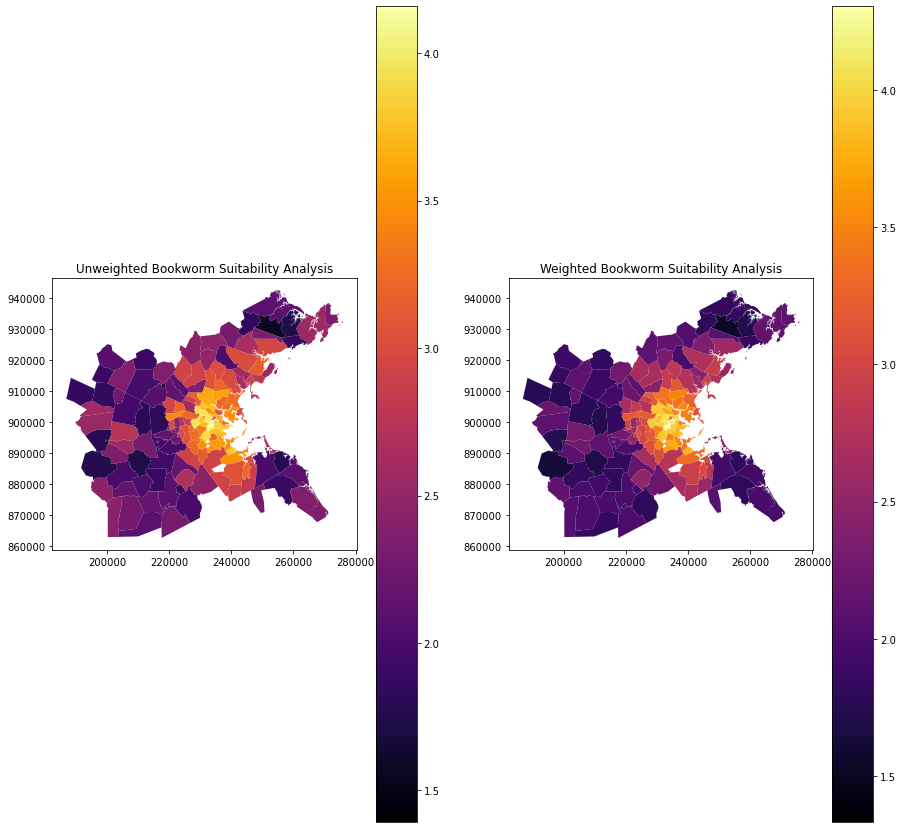

In [30]:
fig, (axun, axw) = plt.subplots(1, 2, figsize = (15, 15))

axun.set_title('Unweighted Bookworm Suitability Analysis')
axw.set_title('Weighted Bookworm Suitability Analysis')
ZCTA_final.plot(column = 'w_suitability', cmap = 'inferno', legend = True, ax = axw)
ZCTA_final.plot(column = 'unw_suitability', cmap = 'inferno', legend = True, ax = axun)

In [31]:
# report first and last ZCTA rankings for both weighted and unweighted

# unweighted rankings
ZCTA_final.sort_values('unw_suitability', ascending = False)[['NAME', 'unw_suitability']].head()
ZCTA_final.sort_values('w_suitability', ascending = False)[['NAME', 'unw_suitability']].head()

min_idx = ZCTA_final['unw_suitability'].idxmin(axis = 0)
max_idx = ZCTA_final['unw_suitability'].idxmax(axis = 0)
print(ZCTA_final.loc[min_idx, ['NAME', 'unw_suitability']])
print(ZCTA_final.loc[max_idx, ['NAME', 'unw_suitability']])

min_idx = ZCTA_final['w_suitability'].idxmin(axis = 0)
max_idx = ZCTA_final['w_suitability'].idxmax(axis = 0)
print(ZCTA_final.loc[min_idx, ['NAME', 'w_suitability']])
print(ZCTA_final.loc[max_idx, ['NAME', 'w_suitability']])

NAME               ZCTA5 01451
unw_suitability       1.393519
Name: 92, dtype: object
NAME               ZCTA5 02115
unw_suitability       4.158947
Name: 67, dtype: object
NAME             ZCTA5 02762
w_suitability       1.333333
Name: 57, dtype: object
NAME             ZCTA5 02115
w_suitability       4.303559
Name: 67, dtype: object
